# Importing libraries and the data

In [3]:
#Importing the relevant libraries for doing the analysis 
import scanpy as sc
import squidpy as sq
import os
import gc
import random
import pandas as pd
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.io  import imread, imsave
import skimage.io
import anndata as ad
import seaborn as sns 
from scipy import stats
import warnings
import shutil
import math


In [2]:
# Setting up the handling with scanpy

# This line sets the verbosity level of the Scanpy library. In this case, it sets it to the highest level (3), which includes errors, warnings, info, and hints
# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3            

# This line prints a header for the log messages, indicating that the log messages are from Scanpy
sc.logging.print_header()

# This line temporarily suppresses the display of warning messages. 
# It sets a filter to ignore any warnings that might occur during the execution of the code.
warnings.filterwarnings('ignore')

# This line sets the default parameters for the figures generated by Scanpy
# It specifies the DPI (dots per inch) of the figures to be 80 and sets the face color of the figures to white.
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.4 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.9.1 pandas==2.0.2 scikit-learn==1.0.2 statsmodels==0.13.5 igraph==0.10.1 pynndescent==0.5.8


In [4]:
# Set up the base directory
base_dir = '/Users/teresaglauner/ark-analysis/data/COL102A_rosetta_1_cellpose_withASCT2_GLUT1_membrane/'

# Set up the directory with the cell tables after running deepcell or cellpose
cell_table_dir = os.path.join(base_dir, "segmentation/cell_table_25")
segmentation_dir = os.path.join(base_dir, "segmentation/cellpose_visualization_25")
image_dir = os.path.join(base_dir, "image_data/")

# Make a folder in the base_dir called "preprocessing_python" and set up here the directory for saving the plots of this notebook
preprocessing_python_dir = os.path.join(base_dir, "preprocessing_python/")

In [ ]:
# Read the cell size normalized table
df = pd.read_csv(os.path.join(cell_table_dir,'cell_table_size_normalized.csv'))

# Looking at your data and preparing it for the following analysis

In [ ]:
# Getting the names of the columns in order to define the relevant channels
df.columns

In [ ]:
# Define channels and background list to be removed
channels = ['ARG1', 'ASCT2', 'ATP5A', 'CA9', 'CD14','CD163', 'STING1',
       'CD20', 'CD3e', 'CD31', 'CD4', 'CD45', 'CD68', 'CD7', 'CD8',
       'CD98', 'CPT1A', 'CS', 'DCN', 'GS', 'MPO', 'MSH2', 'MSH6',
       'CytC', 'FoxP3', 'GLS', 'GLUT1', 'HLADRa', 'Ki67',
       'LDH', 'MCT1', 'PDL1', 'PD1', 'PKM2', 'PanCK', 'SMA', 'Vimentin']
background = ['chan_39', 'chan_48', 'chan_69', 'chan_71', 'Au', 'Noodle', 'Fe']

In [ ]:
# drop background channels - axis=1 specifies that you want to drop columns (as opposed to rows)
df = df.drop(background, axis = 1)

In [ ]:
# Get the names of all unique FOVs 
# The unique() function in pandas is used to extract the unique values from a column
print(df["fov"].unique())

In [ ]:
# If I wanted to get rid of certain FOVs, e.g. some that did not work or should not be included in the analysis 
values_to_remove = ['D7h']

#Filter the DataFrame to exclude rows containing these values
df = df[~df['fov'].isin(values_to_remove)]

# Verify that FOVs have been dropped
print(df["fov"].unique())

# If you wanna rename the fovs:
# df= df.replace({'2023-03-09-ST0026_set1_B10_Mamm': 'B10_BC',...,....})

In [ ]:
# Display the table
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

df


# Cell size exclusion 
We want to get rid of cells that are too small or too big.

In [ ]:
# Summary statistics of the cell size column 
df['cell_size'].describe()

In [ ]:
# Calculate the median from the cell size column
median_value = df['cell_size'].median()
# Display the result
median_value

In [1]:
# Make a density plot of the cell size column

sns.kdeplot(data=df['cell_size'])

# Save the histogram
save_path = os.path.join(preprocessing_python_dir, 'density_plot_cell_size_before_exclusion.png')
plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight', format='png')


NameError: name 'sns' is not defined

In [ ]:
# Sort the cell size column based on its values and then display the highest and lowest values. You can define how many values you want to display. In this case I used 1000. 
sorted_column = df['cell_size'].sort_values()
lowest_values = sorted_column.head(1000)
highest_values = sorted_column.tail(1000)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print("1000 Lowest Values:")
print(lowest_values)
print("\n1000 Highest Values:")
print(highest_values)


In [ ]:
#Set your threshold what you think could be good value to start with to exlcude too big or too small cells. You can get an idea from the information of the previous analysis.
thr_lower = 200
thr_upper=  2500

In [ ]:
# Chooosing a FOV to display if the set threshold makes sense. You can change the FOV again to have more examples.
fov1 = df[df["fov"]=="A1d"]

# Thresholding on one fov
channel_of_interest = pd.cut(fov1["cell_size"], bins=[-float("inf"), thr_lower, thr_upper, float("inf")], labels=[0, 1, 2], right=False).astype(int)
channel_of_interest.value_counts()

In [ ]:
# Categorizing "cell_size" into three categories
fov1["channel_of_interest"] = pd.cut(fov1["cell_size"], bins=[-float("inf"), thr_lower, thr_upper, float("inf")], labels=[0, 1, 2], right=False).astype(int)

# Creating the scatterplot
scatterplot= sns.scatterplot(y=fov1["centroid-0"], x=fov1["centroid-1"], hue=fov1["channel_of_interest"], palette=sns.color_palette("hls", n_colors=3))
plt.gca().invert_yaxis()
scatterplot.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Save the image
save_path = os.path.join(preprocessing_python_dir, 'example_cell_size_image_centroid.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight', format='png')
plt.show()


In [ ]:
# Read the image of the FOV for the overlay of the centroid coordinates and the image from the cellpose visualisation folder.
img = imread(os.path.join(segmentation_dir, 'A1d_nuclear_channel_membrane_channel_overlay.tiff'))
fig, ax =  plt.subplots(1, 1, figsize=(15, 15))
ax.matshow(img, alpha=1)
sns.scatterplot(y=fov1["centroid-0"], x=fov1["centroid-1"], hue=fov1["channel_of_interest"],palette=sns.color_palette("hls", n_colors=3), ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Save the image
save_path = os.path.join(preprocessing_python_dir, 'example_cell_size_image.png')
plt.savefig(save_path, dpi=300, format='png')

In [ ]:
# If you have found a suitable threshold, now you define here the final cutoff values for the top and bottom that you want to remove 
q_low = 200
q_high=  2500

# Filter the df to only include rows where 'cell_size' values are between the thresholds 
df_filtered = df[(df['cell_size'] >= q_low) & (df['cell_size'] <= q_high)]

# Saving the filtered table to the preprocessing folder
save_path = os.path.join(preprocessing_python_dir, 'cell_table_cell_size_filtered.csv')
df_filtered.to_csv(save_path, index=False)

In [ ]:
# If you want to look at the filtered table
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

df_filtered

In [ ]:
# Create a histogram for cell size after filtering the smallest and biggest cells

plt.figure(figsize=(14, 6))
sns.histplot(data=df_filtered, x='cell_size', kde=True)

# Save the histogram
save_path = os.path.join(preprocessing_python_dir, 'histogramm_cell_size_excluded.png')
plt.savefig(save_path, dpi=300, format='png')
plt.show()

In [ ]:
# Create density plot for cell size after filtering the smallest and biggest cells

sns.kdeplot(data=df_filtered['cell_size'])

# Save the histogram
save_path = os.path.join(preprocessing_python_dir, 'density_plot_cell_size_excluded.png')
plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight', format='png')

In [ ]:
# You need to make another table with the cells you have removed to be able to update the cell maks 

# Filter the df to only include rows where 'cell_size' values are below or above the thresholds 
df_cell_size_filtered_away= df[(df['cell_size'] < q_low) | (df['cell_size'] > q_high)]

# Saving the filtered away table to the preprocessing folder
save_path = os.path.join(preprocessing_python_dir, 'cell_table_cell_size_normalized_filtered_away.csv')
df_cell_size_filtered_away.to_csv(save_path, index=False)

# Update cell masks in ark analysis folder after cell size exclusion

Now, you want to update the "cellpose_output" to remove the excluded cells form the segmentation mask. To do so, copy in the ark analysis the "cell_table_export_CellPose" notebook and name it "_cell_size_modified". 

In the 'set up your file paths' change to # set up file paths

tiff_dir = os.path.join(base_dir, "image_data")
cell_table_dir = os.path.join(base_dir, "segmentation/cell_table_cell_size_modified")
deepcell_input_dir = os.path.join(base_dir, "segmentation/cellpose_input")
deepcell_output_dir = os.path.join(base_dir, "segmentation/cellpose_output_cell_size_modified")
deepcell_visualization_dir = os.path.join(base_dir, "segmentation/cellpose_visualization_cell_size_modified")

Run the ark-analysis until 'set up your file paths' and then first continue with the code lines below in this script

In [ ]:
# Read the CSV file containing the cells to be removed
df_cell_size_filtered_away

# Name the directory containing segmentation mask files and give the fov names 
mask_folder = os.path.join(base_dir, "segmentation/cellpose_output_25")
fovList = df_cell_size_filtered_away["fov"].unique()

# Process each row in the DataFrame
for fov in fovList:
    df_fov = df_cell_size_filtered_away[df_cell_size_filtered_away['fov']==fov]
    image_filename = fov + "_whole_cell.tiff"  # Column name for image names
        # Load the segmentation mask image
    segmentation_mask_path = os.path.join(mask_folder, image_filename)
    segmentation_mask = imread(segmentation_mask_path)
    for index, row in df_fov.iterrows():
        
        cells_to_remove = row['label']  # Column name for cell IDs to be removed
        
        segmentation_mask[segmentation_mask == cells_to_remove] = 0

    modified_segmentation_mask_path = os.path.join(base_dir,'segmentation/cellpose_output_cell_size_modified', f'{image_filename}')
    imsave(modified_segmentation_mask_path, segmentation_mask)


In [ ]:
# Now you need to copy the "_nuclear.tiff" images into the new folder so that you can run the ark-analysis 
source_folder = os.path.join(base_dir, "segmentation/cellpose_output_25")
destination_folder = os.path.join(base_dir, "segmentation/cellpose_output_cell_size_modified")

# Iterate through the files in the source folder
for filename in os.listdir(source_folder):
   if filename.endswith("_nuclear.tiff"):
    source_file_path = os.path.join(source_folder, filename)
    destination_file_path = os.path.join(destination_folder, filename)
    
    # Copy the file to the destination folder
    shutil.copy(source_file_path, destination_file_path)
    
print("Files copied successfully.")

Now you can run the rest of the ark-analysis script so that you get a new cell table and the updated visualization images

In [ ]:
# Double-check on one FOV that it worked

# Read the last example image you have used above to define the threshold
img = imread(os.path.join(base_dir,'segmentation/cellpose_visualization_cell_size_modified/A1d_nuclear_channel_membrane_channel_overlay.tiff'))
fig, ax =  plt.subplots(1, 1, figsize=(15, 15))
ax.matshow(img, alpha=1)
sns.scatterplot(y=fov1["centroid-0"], x=fov1["centroid-1"], hue=fov1["channel_of_interest"],palette=sns.color_palette("hls", n_colors=3), ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Save the image
save_path = os.path.join(preprocessing_python_dir, 'cell_size_image_after_removal.png')
plt.savefig(save_path, dpi=300, format='png')


# Nuclei exclusion 
We want to get rid of cells that do not have sufficient nuclei signal

In [ ]:
# Updload the new cell table (the one obtained from ark analysis after cell size removal)

# Read the cell size normalized table
df = pd.read_csv(os.path.join(base_dir,'segmentation/cell_table_cell_size_modified/cell_table_size_normalized.csv'))

In [ ]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

df

In [ ]:
# Summary statistics of the nuclei column 
df['nuclei'].describe()

In [ ]:
# Calculate the median from the nuclei column
median_value = df['nuclei'].median()
# Display the result
median_value

In [ ]:
# Make a density plot of the nuclei column
sns.kdeplot(data=df['nuclei'])

# Save the histogram
save_path = os.path.join(preprocessing_python_dir, 'density_plot_nuclei_before_exclusion.png')
plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight', format='png')


In [ ]:
# Sort the nuclei column based on its values and then display the highest and lowest values. You can change here the number you want 
sorted_column = df['nuclei'].sort_values()
lowest_values = sorted_column.head(1000)
highest_values = sorted_column.tail(1000)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print("3000 Lowest Values:")
print(lowest_values)
print("\n3000 Highest Values:")
print(highest_values)

In [ ]:
# Set your threshold that you think may be correct from the information you got from the codes above
thr_lower = 0.009
thr_upper=  0.9

In [ ]:
# Chooosing a FOV to display if the set threshold makes sense. You can change the FOV again to have more examples.
fov1 = df[df["fov"]=="A1c"]

# Thresholding on one fov
channel_of_interest = pd.cut(fov1["nuclei"], bins=[-float("inf"), thr_lower, thr_upper, float("inf")], labels=[0, 1, 2], right=False).astype(int)
channel_of_interest.value_counts()

In [ ]:
# Categorizing "nuclei" into three categories
fov1["channel_of_interest"] = pd.cut(fov1["nuclei"], bins=[-float("inf"), thr_lower, thr_upper, float("inf")], labels=[0, 1, 2], right=False).astype(int)

# Creating the scatterplot
scatterplot= sns.scatterplot(y=fov1["centroid-0"], x=fov1["centroid-1"], hue=fov1["channel_of_interest"], palette=sns.color_palette("hls", n_colors=3))
plt.gca().invert_yaxis()
scatterplot.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Save the image
save_path = os.path.join(preprocessing_python_dir, 'example2_nuclei_image_centroid.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight', format='png')
plt.show()


In [ ]:
# Read the image of the FOV for the overlay of the centroid coordinates and the image from the cellpose visualisation folder.

#img = imread(os.path.join(base_dir,'segmentation/cellpose_input_25/A1anuclei_proc.tiff'))
img = imread(os.path.join(base_dir,'segmentation/cellpose_visualization_cell_size_modified/A1c_nuclear_channel_membrane_channel_overlay.tiff'))
fig, ax =  plt.subplots(1, 1, figsize=(15, 15))
ax.matshow(img, alpha=1)
sns.scatterplot(y=fov1["centroid-0"], x=fov1["centroid-1"], hue=fov1["channel_of_interest"],palette=sns.color_palette("hls", n_colors=3), ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Save the image
save_path = os.path.join(preprocessing_python_dir, 'example2_nuclei_image.png')
plt.savefig(save_path, dpi=300, format='png')

In [ ]:
# Define the final cutoff values for the top and bottom that you want to remove 
q_low = 0.009
q_high=  0.9

# Filter the df to only include rows where 'nuclei' values are between the thresholds 
df_filtered = df[(df['nuclei'] >= q_low) & (df['nuclei'] <= q_high)]

# Saving the filtered table to the preprocessing folder
save_path = os.path.join(preprocessing_python_dir, 'cell_table_cell_nuclei_normalized_filtered.csv')
df_filtered.to_csv(save_path, index=False)

In [ ]:
# Create a histogram for nuclei after filtering for the cells that do not have sufficient nuclei signal 
plt.figure(figsize=(14, 6))
sns.histplot(data=df_filtered, x='nuclei', kde=True)

# Save the histogram
save_path = os.path.join(preprocessing_python_dir, 'histogramm_nuclei_excluded.png')
plt.savefig(save_path, dpi=300, format='png')
plt.show()

In [ ]:
# Create a density plot for nuclei after filtering for the cells that do not have sufficient nuclei signal 
sns.kdeplot(data=df_filtered['nuclei'])

# Save the histogram
save_path = os.path.join(preprocessing_python_dir, 'density_plot_nuclei_excluded.png')
plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight', format='png')

In [ ]:
# Display the updated table 
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

df_filtered

In [ ]:
# You need to make another table with the cells you have removed to be able to update the cell maks 

# Filter the df to only include rows where 'nuclei' values are below or above the thresholds 
df_nuclei_filtered_away= df[(df['nuclei'] < q_low) | (df['nuclei'] > q_high)]

# Saving the filtered away table to the preprocessing folder
save_path = os.path.join(preprocessing_python_dir, 'cell_nuclei_normalized_filtered_away.csv')
df_nuclei_filtered_away.to_csv(save_path, index=False)

# Update cell masks in ark analysis folder after nuclei exclusion

Now, we want to update the "cellpose_output" to remove the excluded cells form the segmentation mask. To do so, copy in the ark analysis the "cell_table_export_CellPose" notebook and name it "_nuclei_modified". 

In the 'set up your file paths' change to # set up file paths

tiff_dir = os.path.join(base_dir, "image_data")
cell_table_dir = os.path.join(base_dir, "segmentation/cell_table_nuclei_modified")
deepcell_input_dir = os.path.join(base_dir, "segmentation/cellpose_input")
deepcell_output_dir = os.path.join(base_dir, "segmentation/cellpose_output_nuclei_modified")
deepcell_visualization_dir = os.path.join(base_dir, "segmentation/cellpose_visualization_nuclei_modified")

Run the ark-analysis until 'set up your file paths' and then first continue with the code lines below in this script

In [ ]:
# Read the CSV file containing image names and cells to be removed
df_nuclei_filtered_away

# Directory containing segmentation mask files
mask_folder = os.path.join(base_dir, "segmentation/cellpose_output_cell_size_modified")
fovList = df_nuclei_filtered_away["fov"].unique()

# Process each row in the DataFrame
for fov in fovList:
    df_fov = df_nuclei_filtered_away[df_nuclei_filtered_away['fov']==fov]
    image_filename = fov + "_whole_cell.tiff"  # Column name for image names
        # Load the segmentation mask image
    segmentation_mask_path = os.path.join(mask_folder, image_filename)
    segmentation_mask = imread(segmentation_mask_path)
    for index, row in df_fov.iterrows():
        
        cells_to_remove = row['label']  # Column name for cell IDs to be removed
        
        segmentation_mask[segmentation_mask == cells_to_remove] = 0

    modified_segmentation_mask_path = os.path.join(base_dir,'segmentation/cellpose_output_nuclei_modified', f'{image_filename}')
    imsave(modified_segmentation_mask_path, segmentation_mask)

In [ ]:
# Now you need to copy the "_nuclear.tiff" images into the new folder so that you can run the ark-analysis 
source_folder = os.path.join(base_dir, "segmentation/cellpose_output_25")
destination_folder = os.path.join(base_dir, "segmentation/cellpose_output_nuclei_modified")

# Iterate through the files in the source folder
for filename in os.listdir(source_folder):
   if filename.endswith("_nuclear.tiff"):
    source_file_path = os.path.join(source_folder, filename)
    destination_file_path = os.path.join(destination_folder, filename)
    
    # Copy the file to the destination folder
    shutil.copy(source_file_path, destination_file_path)
    
print("Files copied successfully.")

Now you can run the rest of the ark-analysis script so that you get a new cell table and the updated visualization images

In [ ]:
# Double-check on one FOV that it worked

# Read the last example image you have used above to define the threshold
img = imread(os.path.join(base_dir,'segmentation/cellpose_visualization_nuclei_modified/A1c_nuclear_channel_membrane_channel_overlay.tiff'))
fig, ax =  plt.subplots(1, 1, figsize=(15, 15))
ax.matshow(img, alpha=1)
sns.scatterplot(y=fov1["centroid-0"], x=fov1["centroid-1"], hue=fov1["channel_of_interest"],palette=sns.color_palette("hls", n_colors=3), ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Save the image
save_path = os.path.join(preprocessing_python_dir, 'nuclei_image_after_exclusion.png')
plt.savefig(save_path, dpi=300, format='png')

# Further pre-processing after cell size and nuclei exclusion

In [26]:
# Updload the new cell table (the one obtained from ark analysis after nuclei removal)

# Read the cell size normalized table
df = pd.read_csv(os.path.join(base_dir,'segmentation/cell_table_nuclei_modified/cell_table_size_normalized.csv'))

In [27]:
# Getting the names of the columns in order to define the relevant channels
df.columns

Index(['cell_size', 'ARG1', 'ASCT2', 'ATP5A', 'Au', 'CA9', 'CD14', 'CD163',
       'CD20', 'CD31', 'CD3e', 'CD4', 'CD45', 'CD68', 'CD7', 'CD8', 'CD98',
       'CPT1A', 'CS', 'CytC', 'DCN', 'Fe', 'FoxP3', 'GLS', 'GLUT1', 'GS',
       'HLADRa', 'Ki67', 'LDH', 'MCT1', 'MPO', 'MSH2', 'MSH6', 'Noodle', 'PD1',
       'PDL1', 'PKM2', 'PanCK', 'SMA', 'STING1', 'Vimentin', 'chan_39',
       'chan_48', 'chan_69', 'chan_71', 'membrane', 'nuclei', 'label', 'area',
       'eccentricity', 'major_axis_length', 'minor_axis_length', 'perimeter',
       'convex_area', 'equivalent_diameter', 'centroid-0', 'centroid-1',
       'major_minor_axis_ratio', 'perim_square_over_area',
       'major_axis_equiv_diam_ratio', 'convex_hull_resid', 'centroid_dif',
       'num_concavities', 'fov'],
      dtype='object')

In [28]:
# Define channels and background list to be removed
channels = ['ARG1', 'ASCT2', 'ATP5A', 'CA9', 'CD14','CD163', 'STING1',
       'CD20', 'CD3e', 'CD31', 'CD4', 'CD45', 'CD68', 'CD7', 'CD8',
       'CD98', 'CPT1A', 'CS', 'DCN', 'GS', 'MPO', 'MSH2', 'MSH6',
       'CytC', 'FoxP3', 'GLS', 'GLUT1', 'HLADRa', 'Ki67',
       'LDH', 'MCT1', 'PDL1', 'PD1', 'PKM2', 'PanCK', 'SMA', 'Vimentin', 'nuclei', 'membrane']
background = ['chan_39', 'chan_48', 'chan_69', 'chan_71', 'Au', 'Noodle', 'Fe']

In [29]:
# drop background channels - axis=1 specifies that you want to drop columns (as opposed to rows)
df = df.drop(background, axis = 1)

In [9]:
# Get the names of all unique FOVs 
print(df["fov"].unique())

['A1a' 'A1c' 'A1d' 'A1e' 'A1f' 'A1g' 'A1h' 'A1i' 'A1k' 'A1l' 'A1m' 'A1n'
 'A1o' 'A1p' 'A1q' 'A1r' 'A2a' 'A2b' 'A2c' 'A2d' 'A2e' 'A2g' 'A2h' 'A2i'
 'A2k' 'A2l' 'A2m' 'A2n' 'A2o' 'A2p' 'A2q' 'A2r' 'A3a' 'A3b' 'A3c' 'A3d'
 'A3e' 'A3f' 'A3g' 'A3h' 'A3i' 'A3l' 'A3m' 'A3n' 'A3o' 'A3p' 'A3q' 'A3r'
 'A4a' 'A4b' 'A4c' 'A4d' 'A4e' 'A4f' 'A4g' 'A4h' 'A4i' 'A4k' 'A4l' 'A4m'
 'A4n' 'A4o' 'A4p' 'A4q' 'A4r' 'A5a' 'A5b' 'A5c' 'A5d' 'A5e' 'A5f' 'A5g'
 'A5h' 'A5i' 'A5k' 'A5l' 'A5m' 'A5n' 'A5o' 'A5p' 'A5q' 'A5r' 'A6a' 'A6b'
 'A6c' 'A6d' 'A6e' 'A6g' 'A6h' 'A6i' 'A6k' 'A6l' 'A6m' 'A6n' 'A6o' 'A6p'
 'A6q' 'A6r' 'A7a' 'A7b' 'A7c' 'A7d' 'A7f' 'A7g' 'A7h' 'A7i' 'A7k' 'A7l'
 'A7m' 'A7n' 'A7o' 'A7p' 'A7q' 'A7r' 'A8a' 'A8b' 'A8c' 'A8d' 'A8e' 'A8f'
 'A8g' 'A8h' 'A8i' 'A8l' 'A8m' 'A8n' 'A8o' 'A8p' 'A8q' 'A8r' 'A9a' 'A9b'
 'A9c' 'A9d' 'A9e' 'A9f' 'A9g' 'A9h' 'A9i' 'A9k' 'A9l' 'A9m' 'A9n' 'A9o'
 'A9p' 'A9q' 'A9r' 'B1a' 'B1b' 'B1c' 'B1d' 'B1e' 'B1f' 'B1g' 'B1h' 'B1i'
 'B1k' 'B1n' 'B1o' 'B1p' 'B1q' 'B2a' 'B2b' 'B2c' 'B

In [30]:
# Display the statistics of the channels
df[channels].describe()

,ARG1,ASCT2,ATP5A,CA9,CD14,CD163,STING1,CD20,CD3e,CD31,...,LDH,MCT1,PDL1,PD1,PKM2,PanCK,SMA,Vimentin,nuclei,membrane
count,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,...,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000
mean,0.000392,0.002723,0.006398,0.005141,0.000817,0.000139,0.003215,0.000442,0.000317,0.001763,...,0.001166,0.002371,0.000138,0.000070,0.004545,0.004846,0.009097,0.007361,0.067342,0.009336
std,0.000532,0.003812,0.007344,0.007755,0.001530,0.000595,0.003851,0.003184,0.001008,0.004723,...,0.001391,0.004177,0.000328,0.000203,0.005439,0.007169,0.028430,0.015136,0.069935,0.008882
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009000,0.000000
25%,0.000108,0.000505,0.001670,0.001451,0.000161,0.000003,0.000837,0.000019,0.000029,0.000197,...,0.000267,0.000190,0.000026,0.000007,0.001245,0.000722,0.000000,0.000209,0.025371,0.003309
50%,0.000232,0.001481,0.004069,0.003021,0.000312,0.000017,0.001988,0.000077,0.000072,0.000553,...,0.000714,0.000859,0.000067,0.000028,0.002824,0.002448,0.000028,0.000741,0.045537,0.006974
75%,0.000464,0.003439,0.008419,0.005897,0.000753,0.000063,0.004158,0.000212,0.000158,0.001402,...,0.001553,0.002800,0.000143,0.000075,0.005791,0.006102,0.004419,0.008281,0.080352,0.012620
max,0.014808,0.098230,0.114420,0.308817,0.065325,0.069669,0.143536,0.169383,0.090534,0.182880,...,0.057724,0.149854,0.018970,0.054581,0.099937,0.191656,0.510510,0.410730,0.735136,0.178583


# 99.9% percentile normalisation and bringing the values up to CYTOF level:

/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

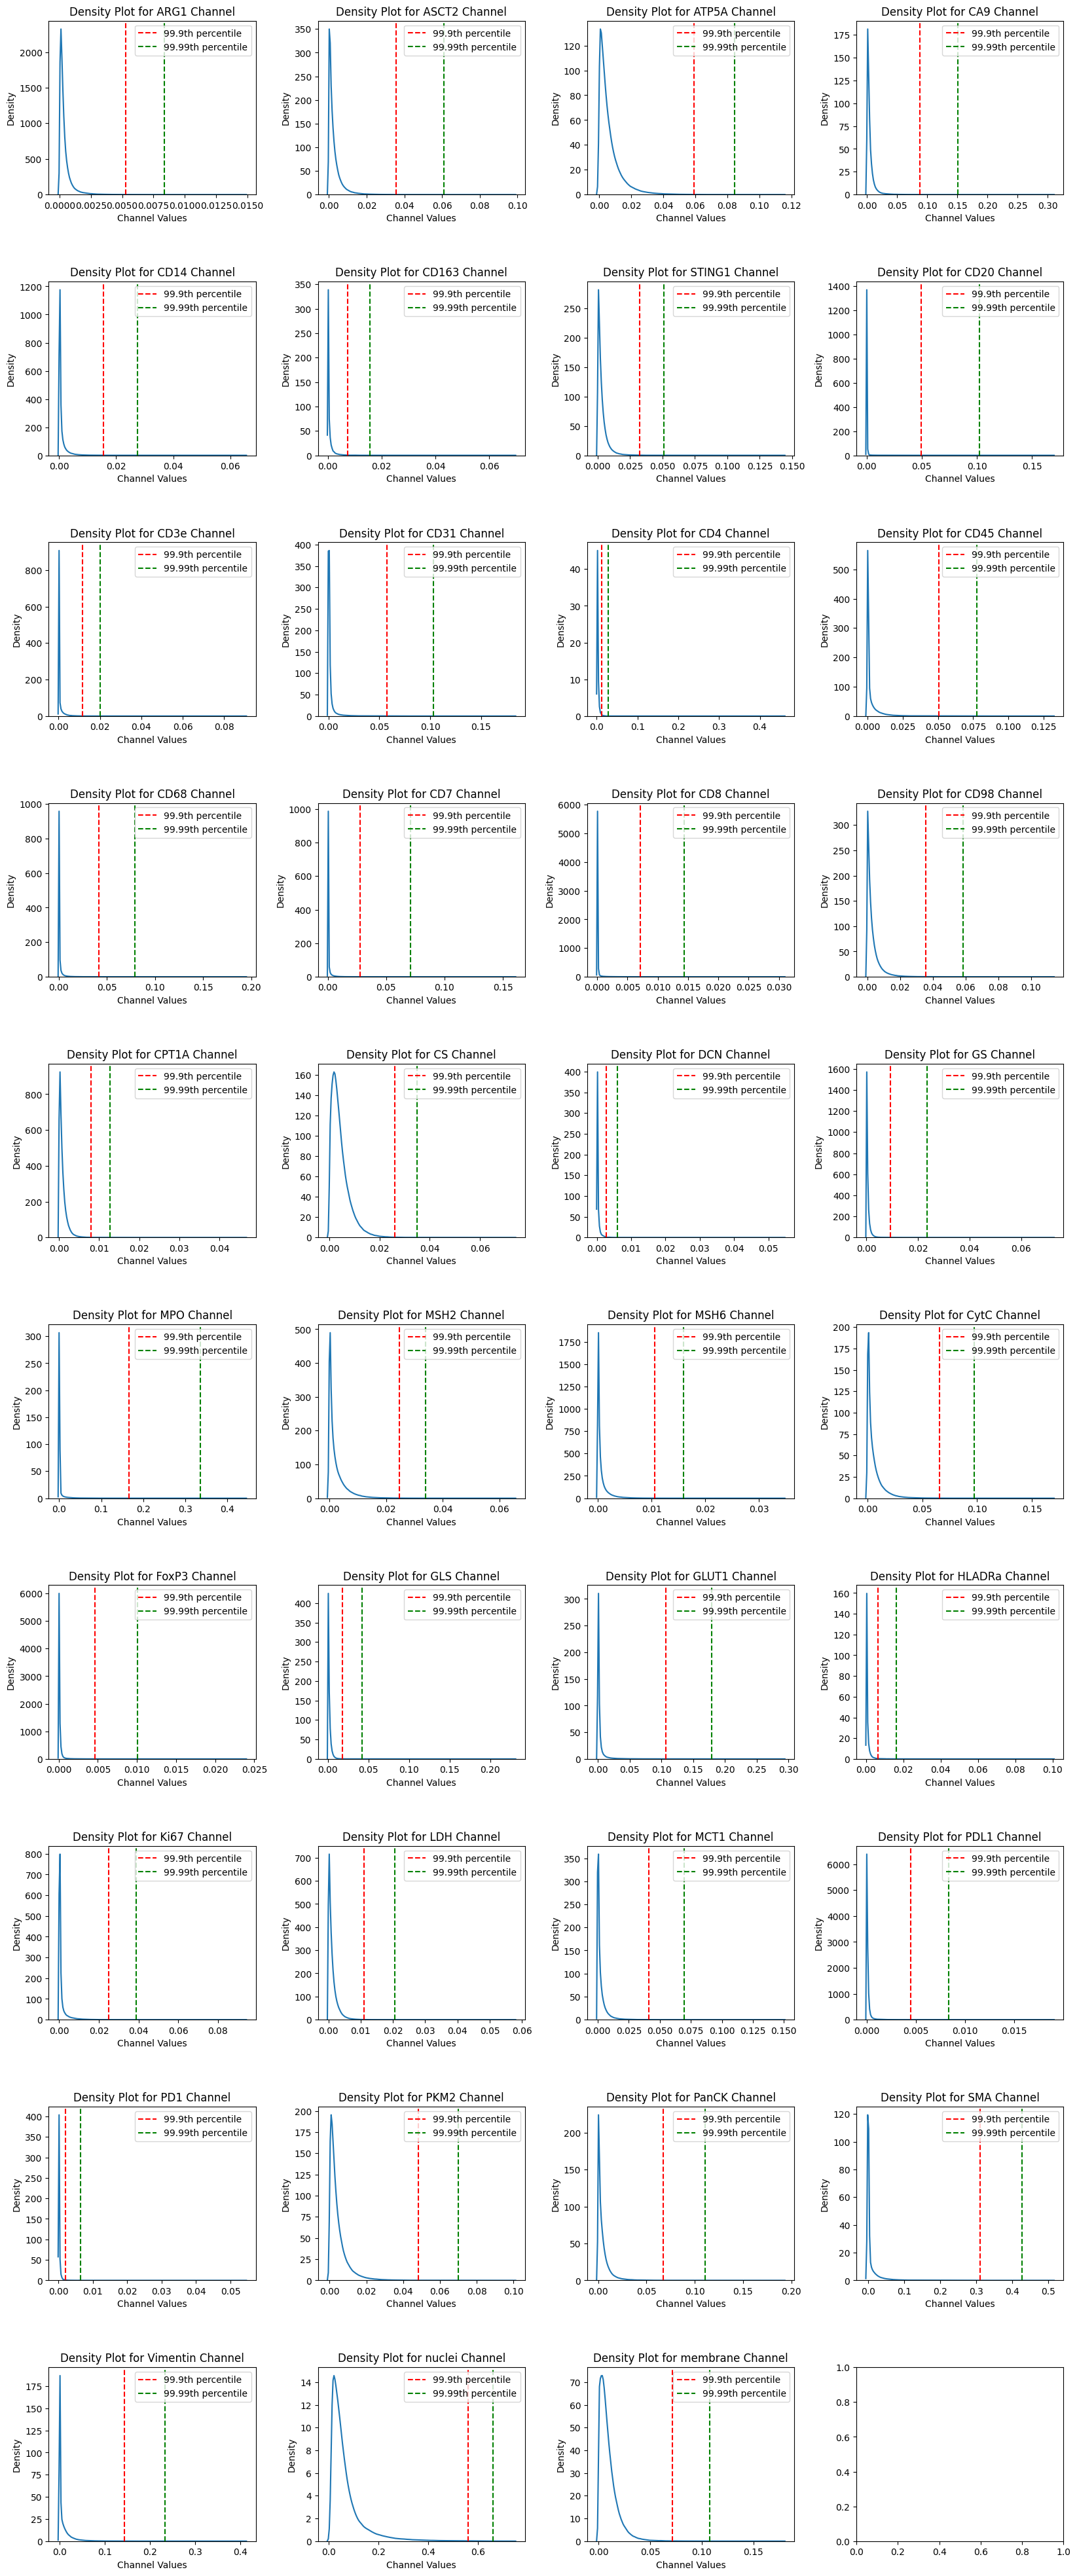

In [10]:
# First, you can check how your channel values look before any pre-processing in a density plot

# Calculate the number of rows and columns for subplots
num_plots = len(channels)
num_cols = 4  # Number of columns in each row
num_rows = math.ceil(num_plots / num_cols)

# Define the size of each subplot
subplot_size = (5, 5)  # Adjust the width and height as needed

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * subplot_size[0], num_rows * subplot_size[1]))
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

# Iterate over each channel and create a density plot
for i, channel in enumerate(channels):
    ax = axes[i]
    sns.kdeplot(data=df[channel], ax=ax)
    
    cytof_99_9 = np.percentile(df[channel], 99.9)
    cytof_99_99 = np.percentile(df[channel], 99.99)
    
    ax.axvline(x=cytof_99_9, color='red', linestyle='--', label='99.9th percentile')
    ax.axvline(x=cytof_99_99, color='green', linestyle='--', label='99.99th percentile')
    
    ax.set_xlabel('Channel Values')
    ax.set_ylabel('Density')
    ax.set_title(f'Density Plot for {channel} Channel')
    
    ax.legend(loc='upper right')  # Move legend outside of the plot area

# Adjust layout and spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# Save the image
save_path = os.path.join(preprocessing_python_dir, 'density_plot_before_tranformation_with percentales.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight', format='png')

# Show the plots
plt.show()

In [31]:
# Then, you can calculate the 99.9% percentale for all channels to ensure that you do not consider any outliers
cytof= df[channels].quantile(.999)
print(cytof)

# Save the file as CSV to have them for later
save_path = os.path.join(preprocessing_python_dir, 'sorted_top99percentile_markers.csv')
cytof.to_csv(save_path, index=False)

ARG1        0.005306
ASCT2       0.035471
ATP5A       0.059450
CA9         0.088198
CD14        0.015635
CD163       0.007454
STING1      0.032329
CD20        0.049506
CD3e        0.011468
CD31        0.057281
CD4         0.012845
CD45        0.050813
CD68        0.041409
CD7         0.027463
CD8         0.007061
CD98        0.035584
CPT1A       0.008060
CS          0.025997
DCN         0.002745
GS          0.009374
MPO         0.166431
MSH2        0.024740
MSH6        0.010511
CytC        0.065395
FoxP3       0.004641
GLS         0.017810
GLUT1       0.107212
HLADRa      0.006375
Ki67        0.024819
LDH         0.011102
MCT1        0.041344
PDL1        0.004457
PD1         0.002137
PKM2        0.048273
PanCK       0.067495
SMA         0.310775
Vimentin    0.143007
nuclei      0.560016
membrane    0.071524
Name: 0.999, dtype: float64


In [32]:
# Now we want to bring this 99.9% percentale of each channel to CYTOF level. We decided to go for 5000.
desired_percentile_value = 10

# Calculate the multiplying factor for each channel 
multiplying_factors = (desired_percentile_value / cytof)

# Print the multiplying factors for each channel
for channel, factor in zip(channels, multiplying_factors):
    print(f"Channel: {channel}, Multiplying Factor: {factor:.2f}")


Channel: ARG1, Multiplying Factor: 188452.49
Channel: ASCT2, Multiplying Factor: 28192.43
Channel: ATP5A, Multiplying Factor: 16820.77
Channel: CA9, Multiplying Factor: 11338.12
Channel: CD14, Multiplying Factor: 63957.07
Channel: CD163, Multiplying Factor: 134162.91
Channel: STING1, Multiplying Factor: 30931.61
Channel: CD20, Multiplying Factor: 20199.67
Channel: CD3e, Multiplying Factor: 87199.65
Channel: CD31, Multiplying Factor: 17457.78
Channel: CD4, Multiplying Factor: 77851.93
Channel: CD45, Multiplying Factor: 19679.88
Channel: CD68, Multiplying Factor: 24149.54
Channel: CD7, Multiplying Factor: 36412.70
Channel: CD8, Multiplying Factor: 141622.71
Channel: CD98, Multiplying Factor: 28102.90
Channel: CPT1A, Multiplying Factor: 124069.09
Channel: CS, Multiplying Factor: 38465.59
Channel: DCN, Multiplying Factor: 364248.36
Channel: GS, Multiplying Factor: 106673.58
Channel: MPO, Multiplying Factor: 6008.51
Channel: MSH2, Multiplying Factor: 40420.16
Channel: MSH6, Multiplying Fact

In [33]:
# Apply the multiplying factors to all values of each channel
for channel, factor in zip(channels, multiplying_factors):
    df[channel] = df[channel] * factor


In [34]:
# Calculate again the 99.9% percentale for all channels to check that it is actually 5000
cytof_verified= df[channels].quantile(.999)
print(cytof_verified)


ARG1        1000.0
ASCT2       1000.0
ATP5A       1000.0
CA9         1000.0
CD14        1000.0
CD163       1000.0
STING1      1000.0
CD20        1000.0
CD3e        1000.0
CD31        1000.0
CD4         1000.0
CD45        1000.0
CD68        1000.0
CD7         1000.0
CD8         1000.0
CD98        1000.0
CPT1A       1000.0
CS          1000.0
DCN         1000.0
GS          1000.0
MPO         1000.0
MSH2        1000.0
MSH6        1000.0
CytC        1000.0
FoxP3       1000.0
GLS         1000.0
GLUT1       1000.0
HLADRa      1000.0
Ki67        1000.0
LDH         1000.0
MCT1        1000.0
PDL1        1000.0
PD1         1000.0
PKM2        1000.0
PanCK       1000.0
SMA         1000.0
Vimentin    1000.0
nuclei      1000.0
membrane    1000.0
Name: 0.999, dtype: float64


In [15]:
# Display the statistics of the channels
df[channels].describe()

,ARG1,ASCT2,ATP5A,CA9,CD14,CD163,STING1,CD20,CD3e,CD31,...,LDH,MCT1,PDL1,PD1,PKM2,PanCK,SMA,Vimentin,nuclei,membrane
count,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,...,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000
mean,36.959064,38.390439,53.813426,29.146771,26.142422,9.291257,49.729697,4.466978,13.822111,15.392360,...,52.527539,28.672230,15.504416,16.311379,47.076787,35.895741,14.636768,25.737065,60.125318,65.265389
std,50.135758,53.731062,61.769446,43.965526,48.934347,39.895851,59.564191,32.155277,43.928230,41.226025,...,62.650474,50.511218,36.787635,47.430826,56.340239,53.109635,45.740460,52.918995,62.439965,62.089947
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.035626,0.000000
25%,10.199990,7.124019,14.045214,8.223681,5.163319,0.185562,12.948649,0.192063,1.270738,1.720478,...,12.029200,2.293068,2.895879,1.619995,12.892047,5.351137,0.000000,0.729210,22.652118,23.129229
50%,21.846280,20.871661,34.225349,17.124196,9.981863,1.164564,30.747193,0.775600,3.120267,4.829115,...,32.151239,10.391677,7.527237,6.579803,29.254327,18.133887,0.045349,2.589185,40.656718,48.754713
75%,43.766880,48.470366,70.808967,33.429498,24.095550,4.202678,64.306364,2.140009,6.893346,12.240122,...,69.937016,33.860587,16.086212,17.634593,59.979840,45.200842,7.109657,28.954479,71.740611,88.222035
max,1395.331957,1384.672173,962.315669,1750.701353,2088.982950,4673.529774,2219.892875,1710.738830,3947.253690,1596.340510,...,2599.847179,1812.300974,2128.181587,12771.055869,1035.121091,1419.789891,821.348586,1436.044572,656.352250,1248.405497


/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

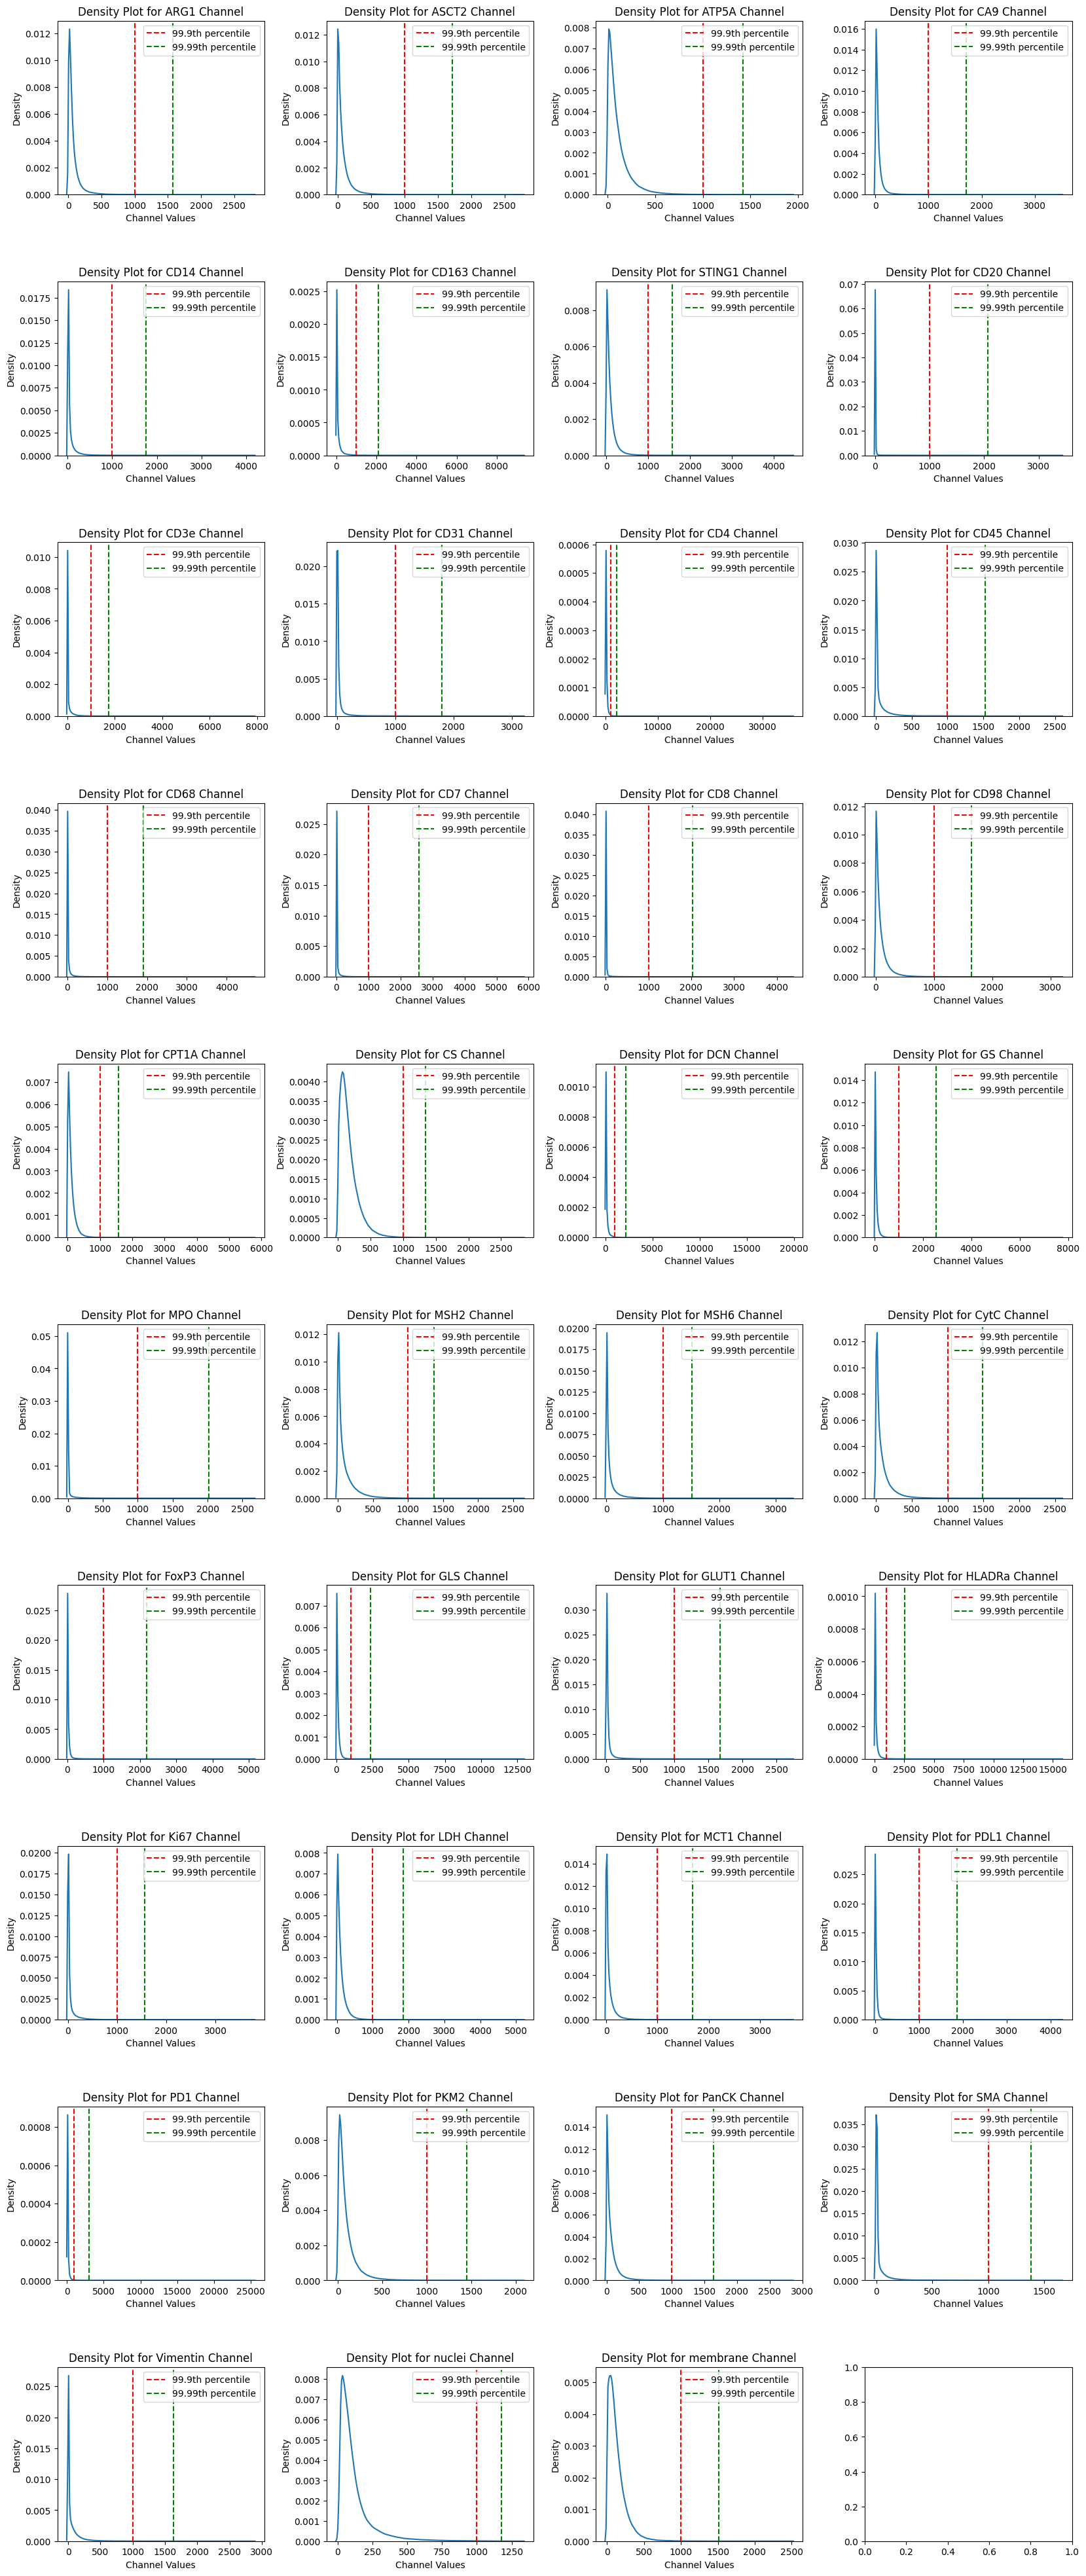

In [35]:
# Visualize the procsessed data in a density plot 

# Calculate the number of rows and columns for subplots
num_plots = len(channels)
num_cols = 4  # Number of columns in each row
num_rows = math.ceil(num_plots / num_cols)

# Define the size of each subplot
subplot_size = (5, 5)  # Adjust the width and height as needed

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * subplot_size[0], num_rows * subplot_size[1]))
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

# Iterate over each channel and create a density plot
for i, channel in enumerate(channels):
    ax = axes[i]
    sns.kdeplot(data=df[channel], ax=ax)
    
    cytof_99_9 = np.percentile(df[channel], 99.9)
    cytof_99_99 = np.percentile(df[channel], 99.99)
    
    ax.axvline(x=cytof_99_9, color='red', linestyle='--', label='99.9th percentile')
    ax.axvline(x=cytof_99_99, color='green', linestyle='--', label='99.99th percentile')
    
    ax.set_xlabel('Channel Values')
    ax.set_ylabel('Density')
    ax.set_title(f'Density Plot for {channel} Channel')
    
    ax.legend(loc='upper right')  # Move legend outside of the plot area

# Adjust layout and spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# Save the image
save_path = os.path.join(preprocessing_python_dir, 'density_plot_before_tranformation_with percentales_cytoflevel_1000.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight', format='png')

# Show the plots
plt.show()

# Arcsinh transformation of the data

In [36]:
# Now, we need to apply arcsin transformation with cofactor of 5 to the channels 
df[channels] = np.arcsinh(df[channels])

In [18]:
# Display the statistics of the  channels
df[channels].describe()

,ARG1,ASCT2,ATP5A,CA9,CD14,CD163,STING1,CD20,CD3e,CD31,...,LDH,MCT1,PDL1,PD1,PKM2,PanCK,SMA,Vimentin,nuclei,membrane
count,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,...,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000
mean,2.178092,2.091321,2.511484,1.972205,1.684724,0.613210,2.444786,0.346741,0.905552,1.124800,...,2.448231,1.626328,1.301885,1.251558,2.410541,1.972797,0.724369,1.287068,2.821589,2.821868
std,1.017310,1.170353,1.141480,0.953452,1.041249,0.916286,1.103023,0.591073,0.989763,1.007473,...,1.178925,1.265127,0.932798,1.043845,1.071989,1.209375,1.207056,1.376025,0.825640,1.045887
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.252754,0.000000
25%,1.461381,1.152315,1.756266,1.272458,0.904283,0.037104,1.680050,0.038403,0.251488,0.337644,...,1.611682,0.443892,0.550887,0.318583,1.675964,0.930171,0.000000,0.145330,2.215926,2.236290
50%,2.180585,2.136149,2.621969,1.944865,1.442012,0.230857,2.516054,0.154504,0.589341,0.856999,...,2.560152,1.478129,1.197781,1.088145,2.466961,1.999978,0.009070,0.497109,2.792633,2.973130
75%,2.865834,2.967312,3.344939,2.598694,2.276331,0.764009,3.248876,0.415907,1.125521,1.627753,...,3.332580,2.611368,1.884994,1.973089,3.179451,2.897870,1.150664,2.456807,3.357978,3.564368
max,6.324600,6.316931,5.953059,6.551483,6.728143,7.533379,6.788925,6.528392,7.364485,6.459181,...,6.946918,6.586064,6.746734,8.538646,6.025989,6.341977,5.794666,6.353360,5.570421,6.213336


/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

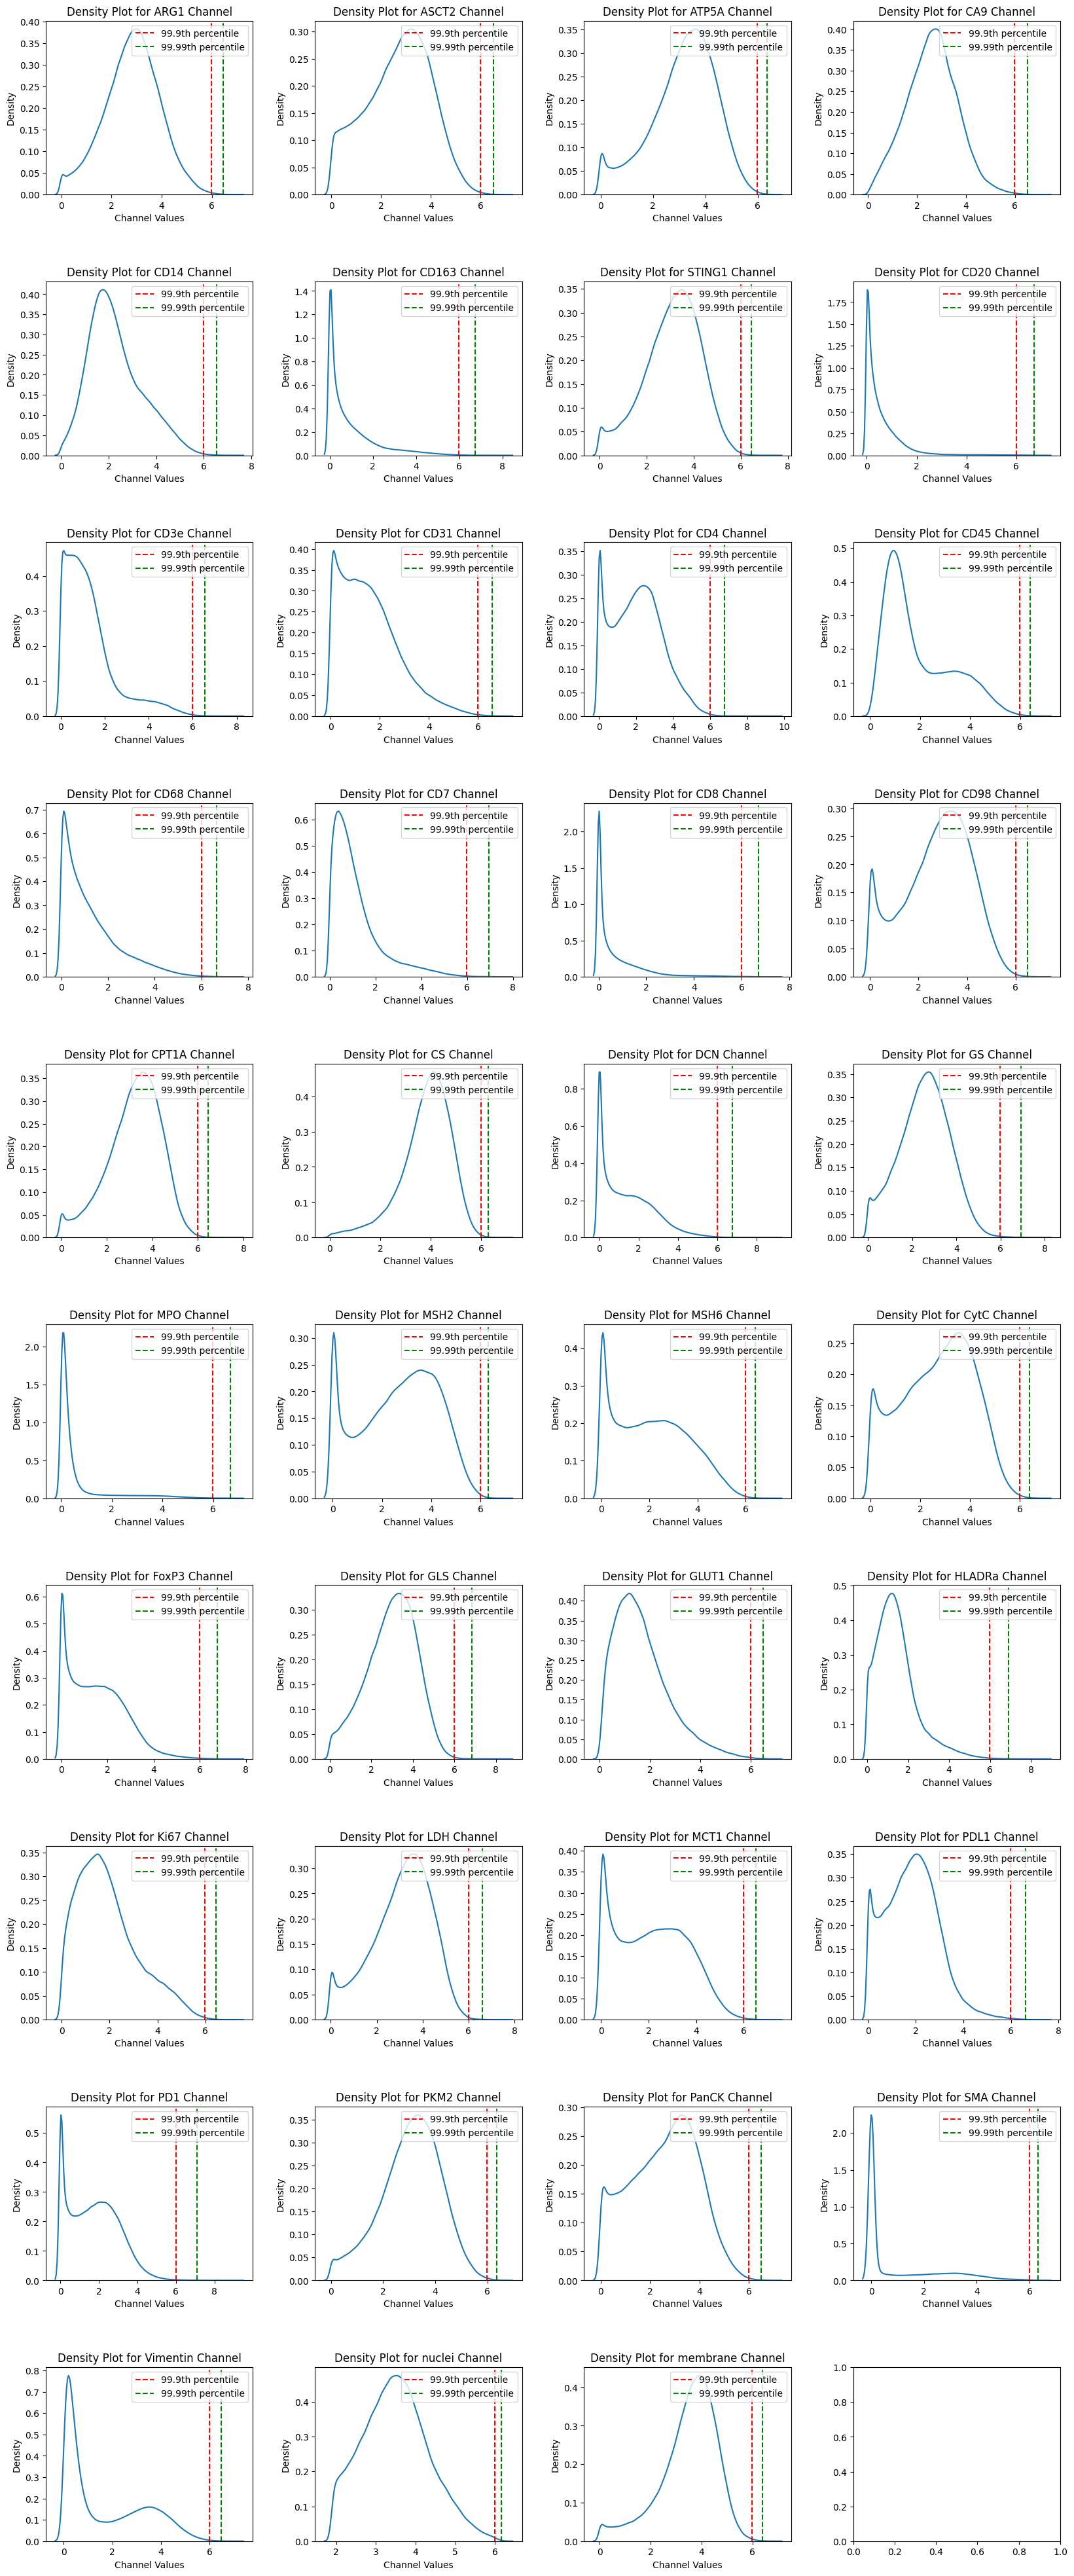

In [37]:
# Visualize the processed data in a density plot 

# Calculate the number of rows and columns for subplots
num_plots = len(channels)
num_cols = 4  # Number of columns in each row
num_rows = math.ceil(num_plots / num_cols)

# Define the size of each subplot
subplot_size = (5, 5)  # Adjust the width and height as needed

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * subplot_size[0], num_rows * subplot_size[1]))
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

# Iterate over each channel and create a density plot
for i, channel in enumerate(channels):
    ax = axes[i]
    sns.kdeplot(data=df[channel], ax=ax)
    
    cytof_99_9 = np.percentile(df[channel], 99.9)
    cytof_99_99 = np.percentile(df[channel], 99.99)
    
    ax.axvline(x=cytof_99_9, color='red', linestyle='--', label='99.9th percentile')
    ax.axvline(x=cytof_99_99, color='green', linestyle='--', label='99.99th percentile')
    
    ax.set_xlabel('Channel Values')
    ax.set_ylabel('Density')
    ax.set_title(f'Density Plot for {channel} Channel')
    
    ax.legend(loc='upper right')  # Move legend outside of the plot area

# Adjust layout and spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# Save the image
save_path = os.path.join(preprocessing_python_dir, 'density_plot_before_tranformation_with percentales_cytoflevel_arcsinhtransformed_1000.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight', format='png')

# Show the plots
plt.show()

# Scaling the data

In [38]:
# Now we want to scale the data so that the values are between 0 and 1

# Calculate the 99.9% percentale for all channels
scaling= df[channels].quantile(.999)
print(scaling)

ARG1        5.991471
ASCT2       5.991471
ATP5A       5.991471
CA9         5.991471
CD14        5.991471
CD163       5.991471
STING1      5.991471
CD20        5.991471
CD3e        5.991471
CD31        5.991471
CD4         5.991471
CD45        5.991471
CD68        5.991471
CD7         5.991471
CD8         5.991471
CD98        5.991471
CPT1A       5.991471
CS          5.991471
DCN         5.991471
GS          5.991471
MPO         5.991471
MSH2        5.991471
MSH6        5.991471
CytC        5.991471
FoxP3       5.991471
GLS         5.991471
GLUT1       5.991471
HLADRa      5.991471
Ki67        5.991471
LDH         5.991471
MCT1        5.991471
PDL1        5.991471
PD1         5.991471
PKM2        5.991471
PanCK       5.991471
SMA         5.991471
Vimentin    5.991471
nuclei      5.991471
membrane    5.991471
Name: 0.999, dtype: float64


In [39]:
df[channels] = df[channels].divide(scaling)

In [40]:
# Double check that the scaling worked 
scaling_verified= df[channels].quantile(.999)
print(scaling_verified)

ARG1        1.0
ASCT2       1.0
ATP5A       1.0
CA9         1.0
CD14        1.0
CD163       1.0
STING1      1.0
CD20        1.0
CD3e        1.0
CD31        1.0
CD4         1.0
CD45        1.0
CD68        1.0
CD7         1.0
CD8         1.0
CD98        1.0
CPT1A       1.0
CS          1.0
DCN         1.0
GS          1.0
MPO         1.0
MSH2        1.0
MSH6        1.0
CytC        1.0
FoxP3       1.0
GLS         1.0
GLUT1       1.0
HLADRa      1.0
Ki67        1.0
LDH         1.0
MCT1        1.0
PDL1        1.0
PD1         1.0
PKM2        1.0
PanCK       1.0
SMA         1.0
Vimentin    1.0
nuclei      1.0
membrane    1.0
Name: 0.999, dtype: float64


In [ ]:
# Display the statistics of the scaled channels
df[channels].describe()

/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

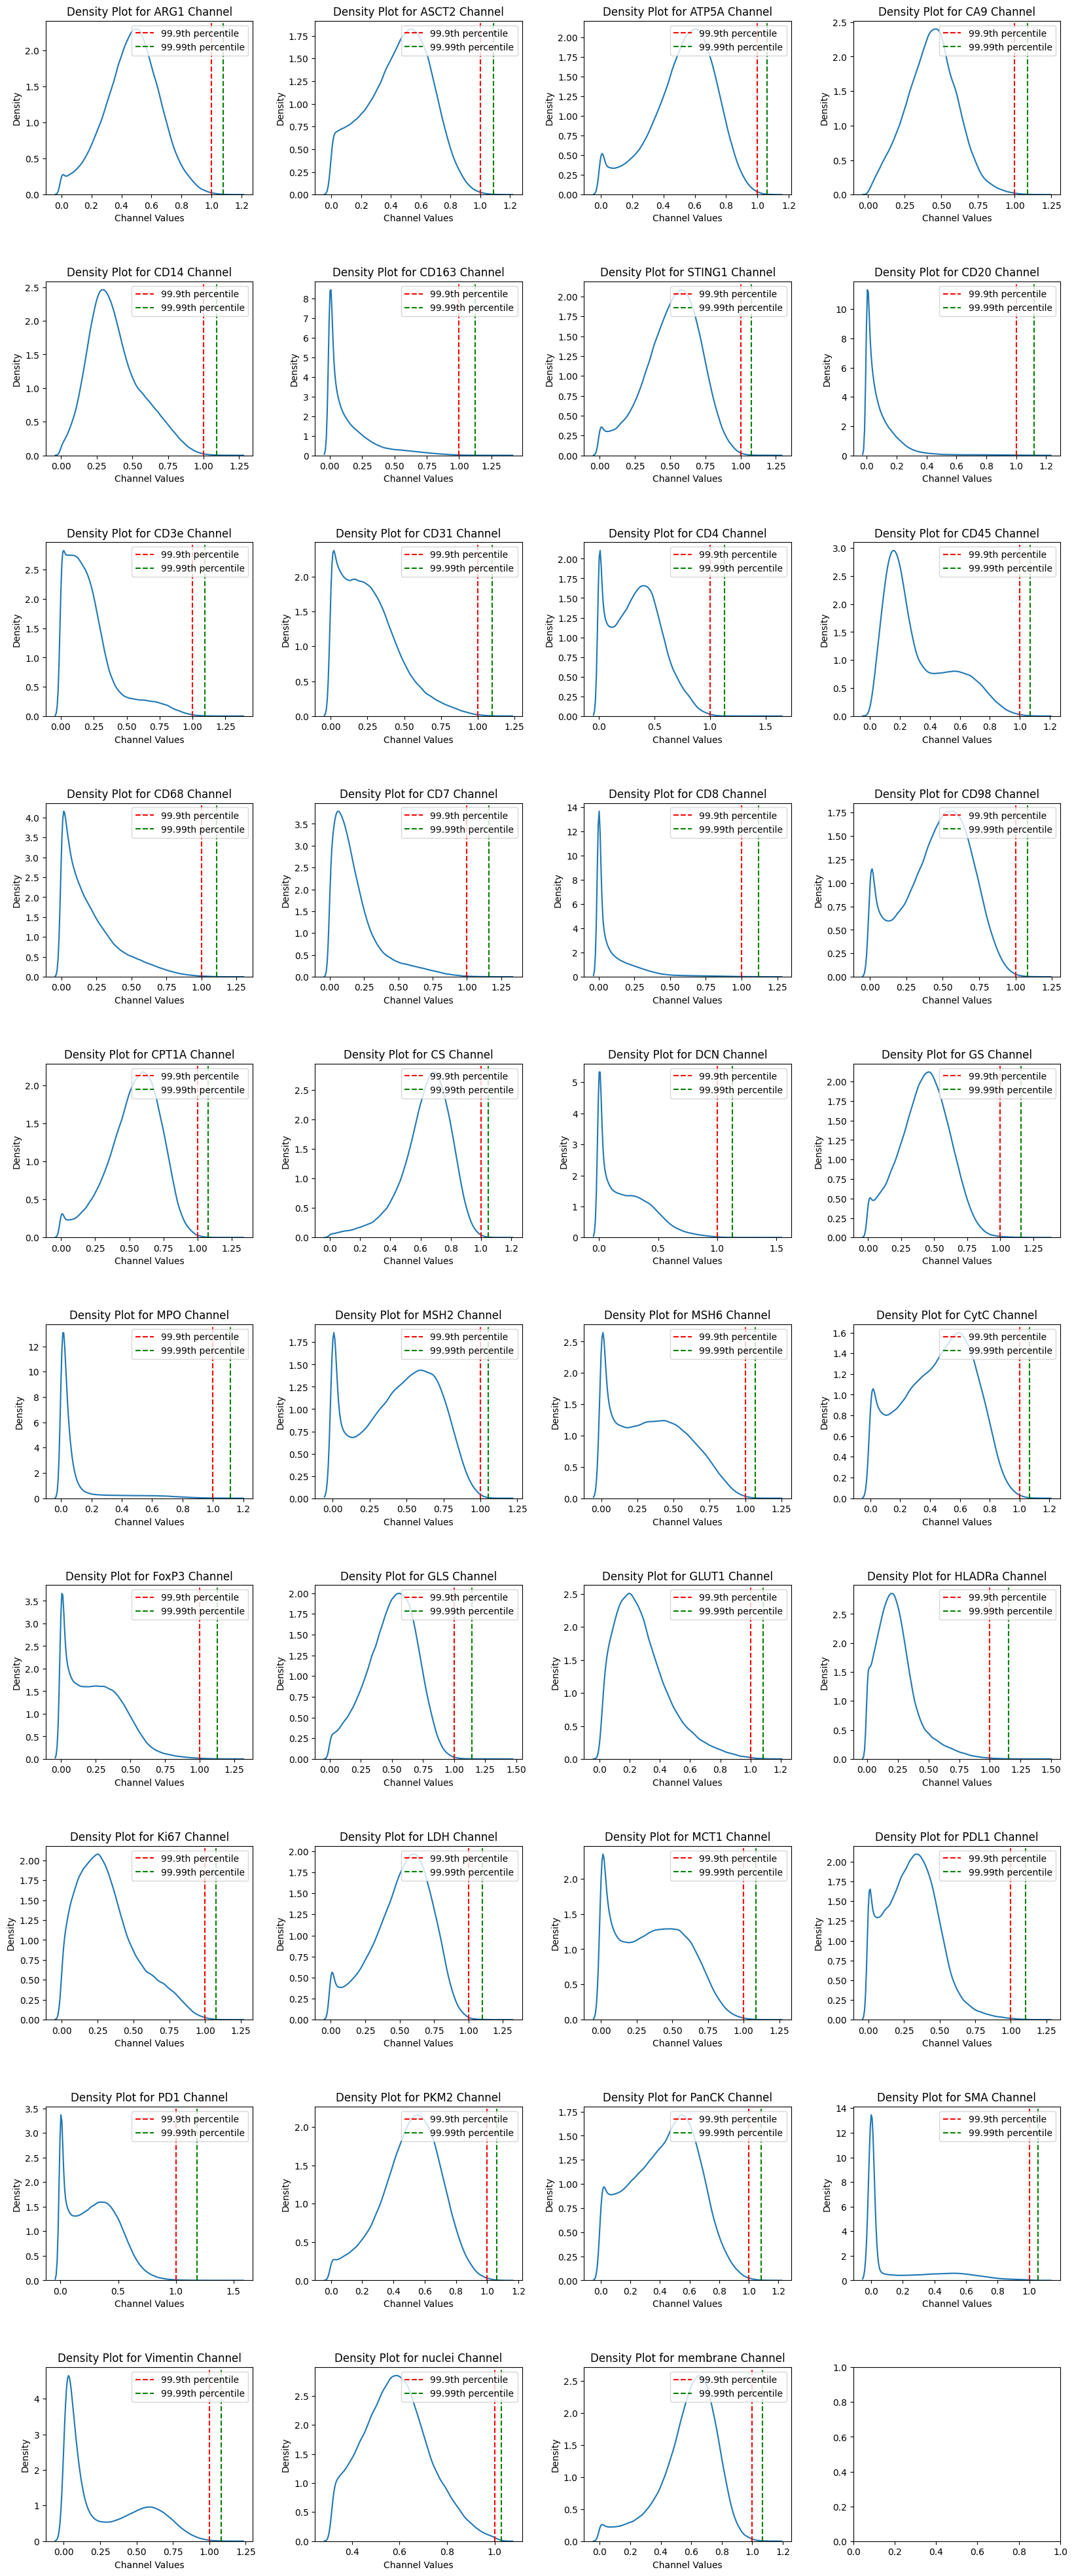

In [41]:
# Visualize the processed data in a density plot 

# Calculate the number of rows and columns for subplots
num_plots = len(channels)
num_cols = 4  # Number of columns in each row
num_rows = math.ceil(num_plots / num_cols)

# Define the size of each subplot
subplot_size = (5, 5)  # Adjust the width and height as needed

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * subplot_size[0], num_rows * subplot_size[1]))
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

# Iterate over each channel and create a density plot
for i, channel in enumerate(channels):
    ax = axes[i]
    sns.kdeplot(data=df[channel], ax=ax)
    
    cytof_99_9 = np.percentile(df[channel], 99.9)
    cytof_99_99 = np.percentile(df[channel], 99.99)
    
    ax.axvline(x=cytof_99_9, color='red', linestyle='--', label='99.9th percentile')
    ax.axvline(x=cytof_99_99, color='green', linestyle='--', label='99.99th percentile')
    
    ax.set_xlabel('Channel Values')
    ax.set_ylabel('Density')
    ax.set_title(f'Density Plot for {channel} Channel')
    
    ax.legend(loc='upper right')  # Move legend outside of the plot area

# Adjust layout and spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# Save the image
save_path = os.path.join(preprocessing_python_dir, 'density_plot_before_tranformation_with percentales_cytoflevel_arcsinhtransformed_scaled_1000.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight', format='png')

# Show the plots
plt.show()

/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

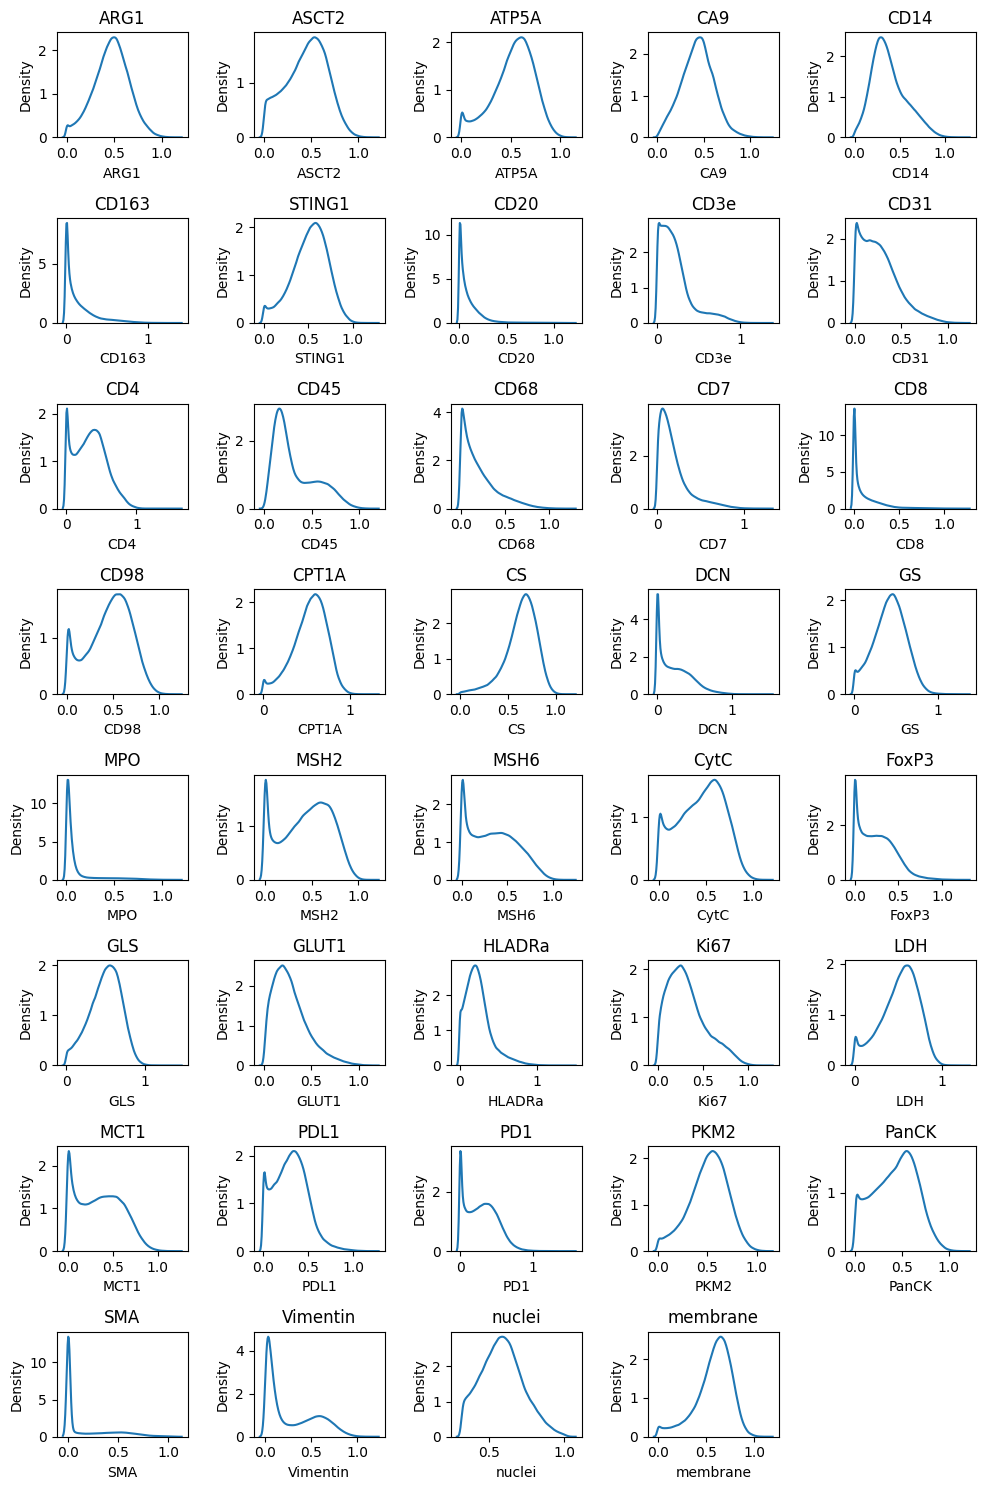

In [42]:
# Visualize the processed data in another format of a  density plot 

# Specify the columns to generate density plots for looking at your data
channels

# Calculate the number of rows and columns for the subplots based on the number of columns
num_plots = len(channels)
num_cols = 5
num_rows = (num_plots - 1) // num_cols + 1

# Calculate the figure size based on the number of columns (adjust the values as needed)
fig_width = 10
fig_height = 15

# Create a figure with subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(fig_width, fig_height))

# Generate density plots for each column and plot them in separate subplots
for i, column in enumerate(channels):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data=df, x=column, ax=axes[row, col])
    axes[row, col].set_title(column)

# Remove any unused subplots
if num_plots < num_rows * num_cols:
    for i in range(num_plots, num_rows * num_cols):
        fig.delaxes(axes[i // num_cols, i % num_cols])

# Adjust the layout and spacing between subplots
plt.tight_layout()

# Save the plot to a file
save_path = os.path.join(preprocessing_python_dir, 'smaller_density_final_1000.png')
plt.savefig(save_path, dpi=300, format='png')

# Display the figure
plt.show()

# Saving the pre-processed data for further analysis, e.g. cell type annotation

In [43]:
# Now, you can  save the filtered, arcsinh transformed and scaled data as csv file - this is the file you can use to continue with cell type annotation
save_path = os.path.join(cell_table_dir, 'cell_table_size_normalized_processed_TG_1000.csv')
df.to_csv(save_path, index=False)

# Some further add on
If you want to look at specific cells (label, FOV) and see where there are in the density plot of certain channels. This could be a good way to figure out if we need to set a certain threshold for values

In [ ]:
# Values from the "label" and "fov" columns that you want to mark
labels_and_fov_to_mark = [(340, "A1a"), (642, "A1a"), (175, "A1c"), (1122, "A1c"), (1443, "A1c")]

# Calculate the number of rows and columns for subplots
num_plots = len(channels)
num_cols = 4  # Number of columns in each row
num_rows = math.ceil(num_plots / num_cols)

# Define the size of each subplot
subplot_size = (5, 5)  # Adjust the width and height as needed

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * subplot_size[0], num_rows * subplot_size[1]))
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

# Create a colormap with unique colors for each combination of "label" and "fov"
unique_labels_fov_combinations = list(set(labels_and_fov_to_mark))
color_map = plt.cm.get_cmap('rainbow', len(unique_labels_fov_combinations))

# Create a dictionary to map labels and fov combinations to colors
color_dict = {combo: color_map(i) for i, combo in enumerate(unique_labels_fov_combinations)}

# Iterate through channels and create density plots within subplots
for i, channel in enumerate(channels):
    # Create a density plot using Seaborn within the current subplot
    sns.kdeplot(data=df[channel], shade=False, ax=axes[i])
    
    # Mark the specified values on the density plot with vertical lines
    for label_value, fov_value in labels_and_fov_to_mark:
        matching_rows = df[(df['label'] == label_value) & (df['fov'] == fov_value)]
        if not matching_rows.empty:
             corresponding_value = matching_rows[channel].values[0]
             color = color_dict[(label_value, fov_value)]  # Get the color for this combination
             axes[i].axvline(x=corresponding_value, color=color, linestyle='--', label=f'Label {label_value}, FOV {fov_value}')
    
    # Customize the subplot
    axes[i].set_title(f"Density Plot of {channel} with Marked Points")
    axes[i].set_xlabel(channel)
    axes[i].set_ylabel("Density")
    axes[i].legend()

# Adjust layout for better visualization
plt.tight_layout()

# Show the subplots
plt.show()
